In [48]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
np.set_printoptions(precision=4, suppress=True, threshold=1000)

## 1: Normally-encoded full dataset

In [2]:
# import encoded and original data
with np.load('normally-encoded-mnist.npz') as data:
    x_train1 = data['x_train']
    x_test1 = data['x_test']
    x_train_encoded1 = data['x_train_encoded']
    x_test_encoded1 = data['x_test_encoded']
    A1 = data['A']

### 1.1: Single-layer linear network
#### Results - Noise dominates reconstructed images although outlines of the original digits are now visible.

In [3]:
# single-layer linear network to imitate right-inverse
model11 = tf.keras.Sequential([
    tf.keras.layers.Dense(784, input_shape=(3920,), use_bias=False)
])
loss_fn = tf.keras.losses.MeanSquaredError()
model11.compile(optimizer='adam', loss=loss_fn)
#model11.summary()

In [5]:
# train network
model11.fit(x_train_encoded1, x_train1, epochs=10, verbose=1)

Epoch 1/10
1875/1875 [==============================] - 30s 16ms/step - loss: 3.4375
Epoch 2/10
1875/1875 [==============================] - 33s 18ms/step - loss: 3.0464
Epoch 3/10
1875/1875 [==============================] - 28s 15ms/step - loss: 2.9639
Epoch 4/10
1875/1875 [==============================] - 29s 15ms/step - loss: 3.2811
Epoch 5/10
1875/1875 [==============================] - 28s 15ms/step - loss: 2.9322
Epoch 6/10
1875/1875 [==============================] - 28s 15ms/step - loss: 3.5134
Epoch 7/10
1875/1875 [==============================] - 28s 15ms/step - loss: 3.0414
Epoch 8/10
1875/1875 [==============================] - 28s 15ms/step - loss: 2.8278
Epoch 9/10
1875/1875 [==============================] - 28s 15ms/step - loss: 3.2668
Epoch 10/10
1875/1875 [==============================] - 29s 15ms/step - loss: 3.5101


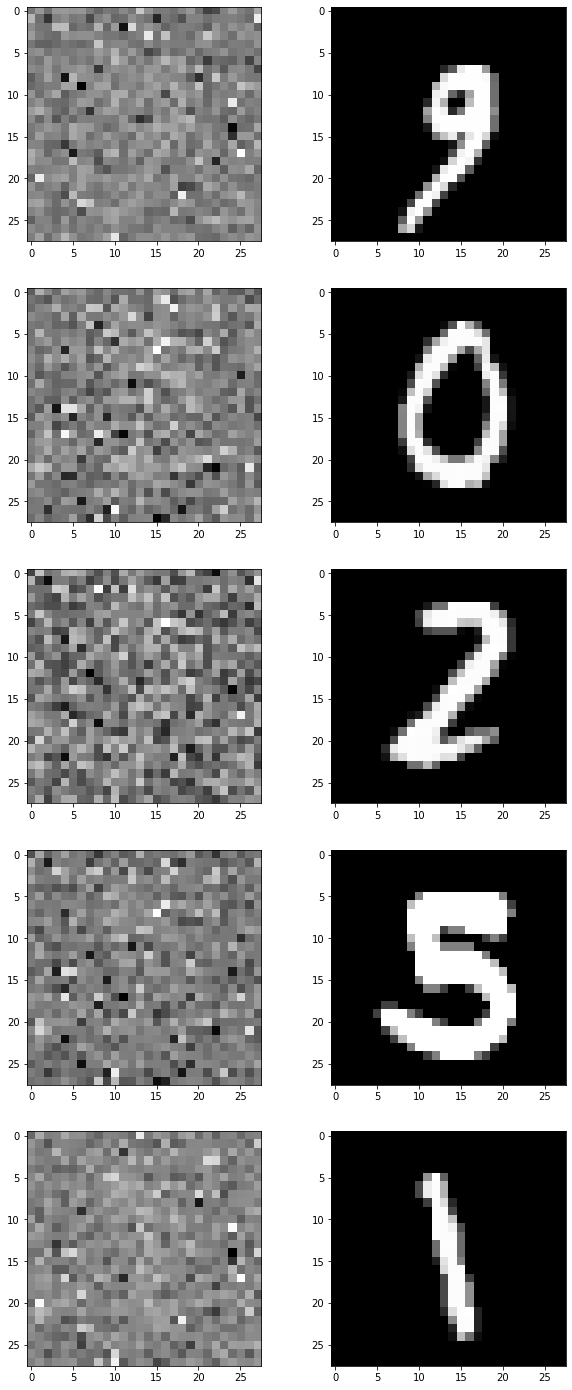

In [6]:
# look at sample reconstructed images
fig, axs = plt.subplots(5,2,figsize=(10,25))
original_images = np.reshape(x_test1[1000:1005,:], (5,28,28))
output_images = np.reshape(model11(x_test_encoded1[1000:1005,:]), (5,28,28))
for i in range(5):
    axs[i,0].imshow(output_images[i,:,:],
                    cmap='gray')
    axs[i,1].imshow(original_images[i,:,:],
                    cmap='gray')

### 1.2: Nonlinear network with two hidden layers
#### Results - Model outputs the same superposition of all the training data for each input image

In [19]:
# deep, nonlinear network with MeanSquaredError
model12 = tf.keras.Sequential([
    tf.keras.layers.Dense(2000, activation='relu', input_shape=(3920,)),
    tf.keras.layers.Dense(1000, activation='relu'),
    tf.keras.layers.Dense(784)
])
loss_fn = tf.keras.losses.MeanSquaredError()
model12.compile(optimizer='adam',
             loss=loss_fn)
#model12.summary()

In [21]:
model12.fit(x_train_encoded1, x_train1, epochs=5, verbose=1)

Epoch 1/5
1875/1875 [==============================] - 101s 53ms/step - loss: 0.1287
Epoch 2/5
1875/1875 [==============================] - 113s 60ms/step - loss: 0.0673
Epoch 3/5
1875/1875 [==============================] - 114s 61ms/step - loss: 0.0673
Epoch 4/5
1875/1875 [==============================] - 109s 58ms/step - loss: 0.0673
Epoch 5/5
1875/1875 [==============================] - 106s 56ms/step - loss: 0.0673


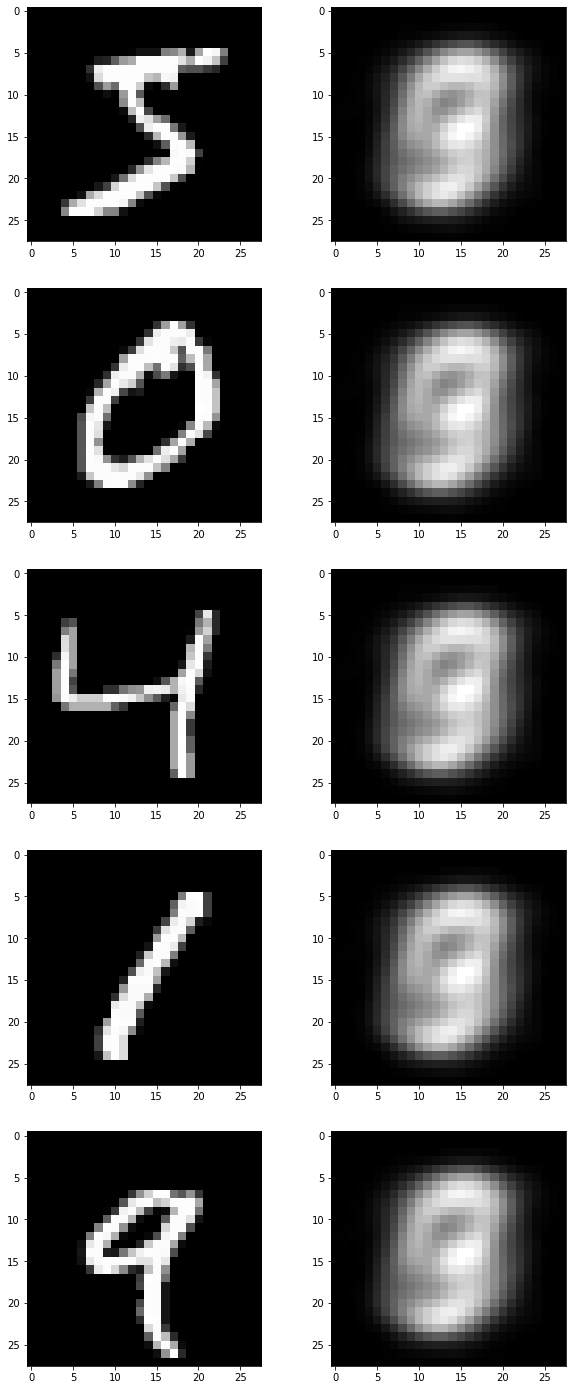

In [22]:
# look at sample reconstructed images
fig, axs = plt.subplots(5,2,figsize=(10,25))
original_images = np.reshape(x_train1[:5,:], (5,28,28))
output_images = np.reshape(model12(x_train_encoded1[:5,:]), (5,28,28))
for i in range(5):
    axs[i,0].imshow(original_images[i,:,:],
                    cmap='gray')
    axs[i,1].imshow(output_images[i,:,:],
                    cmap='gray')

## 2: Outputting the Jacobian
### Demonstrate tensorflow.GradientTape API, compare Jacobian and neuron weights of a small, linear, unbiased neural-network

In [35]:
# initialize linear model with 10x5 weights, no bias, no activation function
model2 = tf.keras.Sequential([
    tf.keras.layers.Dense(5, input_shape=(10,), use_bias=False)
])
loss_fn = tf.keras.losses.MeanSquaredError()
model2.compile(optimizer='adam', loss=loss_fn)

In [34]:
# take "tape" of forward operation
x = tf.Variable([[1.,2,3,4,5,6,7,8,9,10]])
with tf.GradientTape() as tape:
    y = model2(x)

# output gradient of target w.r.t. sources
j = tape.jacobian(y, x)
weights = model1.layers[0].kernel
print('WEIGHTS:')
print(weights)
print('JACOBIAN:')
print(j)

WEIGHTS:
<tf.Variable 'dense_10/kernel:0' shape=(10, 5) dtype=float32, numpy=
array([[ 0.12,  0.18,  0.59, -0.26, -0.02],
       [-0.4 ,  0.57, -0.55,  0.32,  0.37],
       [ 0.15, -0.57, -0.39, -0.26,  0.62],
       [-0.07,  0.33,  0.2 ,  0.46,  0.49],
       [ 0.32,  0.18,  0.32, -0.17, -0.33],
       [ 0.36, -0.31, -0.07, -0.58, -0.05],
       [-0.6 , -0.13,  0.44,  0.13,  0.11],
       [ 0.52, -0.58, -0.12,  0.24, -0.49],
       [-0.08, -0.32,  0.61,  0.44, -0.54],
       [ 0.1 , -0.26,  0.12, -0.24, -0.45]], dtype=float32)>
JACOBIAN:
tf.Tensor(
[[[[ 0.12 -0.4   0.15 -0.07  0.32  0.36 -0.6   0.52 -0.08  0.1 ]]

  [[ 0.18  0.57 -0.57  0.33  0.18 -0.31 -0.13 -0.58 -0.32 -0.26]]

  [[ 0.59 -0.55 -0.39  0.2   0.32 -0.07  0.44 -0.12  0.61  0.12]]

  [[-0.26  0.32 -0.26  0.46 -0.17 -0.58  0.13  0.24  0.44 -0.24]]

  [[-0.02  0.37  0.62  0.49 -0.33 -0.05  0.11 -0.49 -0.54 -0.45]]]], shape=(1, 5, 1, 10), dtype=float32)


In [37]:
print(x @ weights)
print(y)

tf.Tensor([[  3.6  -11.08   9.17   1.63  -9.95]], shape=(1, 5), dtype=float32)
tf.Tensor([[  3.6  -11.08   9.17   1.63  -9.95]], shape=(1, 5), dtype=float32)


## 3: Reconstruction of cropped (5x5 pixel) MNIST dataset

In [9]:
# import MNIST data set with 60,000 28x28 training images
# and 10,000 28x28 testing images
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# normalize pixel brightnesses from 0-255 -> (0,1)
x_train, x_test = x_train / 255.0, x_test / 255.0

# take middle-ish 5x5 section of 28x28 images
x_train3 = np.reshape(x_train[:,11:16,11:16], (60000,25))
x_test3 = np.reshape(x_test[:,11:16,11:16], (10000,25))

### 3.1: Use long encoding matrix (25x100), linear neural-network
#### Results - The linear neural-network gets close (compared to the 28x28 case) to a right inverse of the encoding matrix A, but the optimization process used by Tensorflow never converges to it.

In [10]:
# encode training data
A3 = np.random.randn(25,100)
if np.linalg.matrix_rank(A3) == 25:
    A_sharp3 = np.linalg.pinv(A3)
    # x.shape = (N, d), A.shape = (d, n) -> output shape of (N, n)
    x_train_encoded3 = x_train3 @ A3
    x_test_encoded3 = x_test3 @ A3
else:
    print('Not full rank')

In [28]:
# set up model
model31 = tf.keras.Sequential([
    tf.keras.layers.Dense(25, input_shape=(100,), use_bias=False)
])
loss_fn = tf.keras.losses.MeanSquaredError()
model31.compile(optimizer='adam', loss=loss_fn)
model31.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 25)                2500      
Total params: 2,500
Trainable params: 2,500
Non-trainable params: 0
_________________________________________________________________


In [29]:
# train model
model31.fit(x_train_encoded3, x_train3, epochs=10, verbose=1)

Epoch 1/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.1975
Epoch 2/10
1875/1875 [==============================] - 2s 1ms/step - loss: 1.5442e-04
Epoch 3/10
1875/1875 [==============================] - 2s 1ms/step - loss: 7.8705e-06
Epoch 4/10
1875/1875 [==============================] - 2s 1ms/step - loss: 4.9877e-05
Epoch 5/10
1875/1875 [==============================] - 3s 2ms/step - loss: 1.3958e-04
Epoch 6/10
1875/1875 [==============================] - 3s 2ms/step - loss: 1.1736e-04
Epoch 7/10
1875/1875 [==============================] - 3s 2ms/step - loss: 1.2843e-04
Epoch 8/10
1875/1875 [==============================] - 3s 2ms/step - loss: 1.4159e-04
Epoch 9/10
1875/1875 [==============================] - 3s 2ms/step - loss: 1.3056e-04
Epoch 10/10
1875/1875 [==============================] - 3s 2ms/step - loss: 1.3379e-04


In [46]:
# see how close each is to being a right-inverse of A
print('||AA# - I||')
print(np.linalg.norm(A3 @ A_sharp3 - np.eye(25)))

A_prime31 = model31.layers[0].kernel
print("||AA' - I||")
print(np.linalg.norm(A3 @ A_prime3 - np.eye(25)))

||AA# - I||
1.0865704195721047e-14
||AA' - I||
0.087304756


In [47]:
# compare weights and A# pseudo inverse
print('WEIGHTS:')
print(A_prime31)
print('A# PSEUDO-INVERSE:')
print(tf.constant(A_sharp3))

WEIGHTS:
<tf.Variable 'dense_4/kernel:0' shape=(100, 25) dtype=float32, numpy=
array([[-0.11,  0.16,  0.11, ..., -0.05, -0.22,  0.07],
       [ 0.05,  0.17, -0.02, ...,  0.06, -0.03,  0.09],
       [-0.06,  0.01,  0.17, ..., -0.16,  0.12, -0.2 ],
       ...,
       [ 0.08, -0.02, -0.11, ..., -0.11, -0.14,  0.06],
       [ 0.07,  0.11,  0.31, ...,  0.09, -0.06,  0.08],
       [ 0.13, -0.13,  0.05, ..., -0.04,  0.04,  0.05]], dtype=float32)>
A# PSEUDO-INVERSE:
tf.Tensor(
[[-0.   -0.01  0.01 ...  0.02 -0.02 -0.01]
 [-0.01 -0.02 -0.01 ...  0.03  0.01 -0.01]
 [-0.    0.01  0.01 ... -0.   -0.01  0.01]
 ...
 [-0.01 -0.01 -0.   ... -0.02 -0.01  0.01]
 [-0.    0.01 -0.   ...  0.   -0.01 -0.01]
 [ 0.    0.01  0.01 ...  0.   -0.01 -0.02]], shape=(100, 25), dtype=float64)


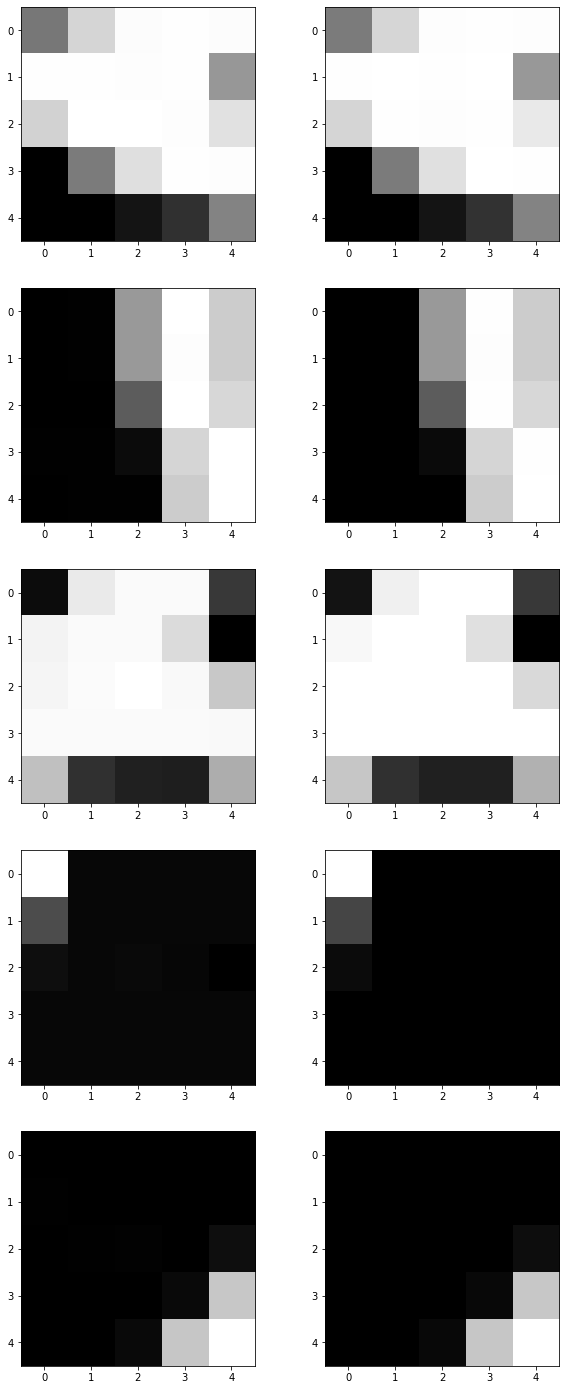

In [35]:
# look at sample reconstructed images
fig, axs = plt.subplots(5,2,figsize=(10,25))
real_images = np.reshape(x_test3[30:35,:], (5,5,5))
output_images = np.reshape(model31(x_test_encoded3[30:35,:]), (5,5,5))
for i in range(5):
    axs[i,0].imshow(output_images[i,:,:],
                    cmap='gray')
    axs[i,1].imshow(real_images[i,:,:],
                    cmap='gray')

### 3.2: Same network but with basic SGD optimization instead of the default Adam algorithm
#### Results - The SGD optimization successfully converges to a weight matrix that is a right-inverse of A

In [38]:
# set up model
model32 = tf.keras.Sequential([
    tf.keras.layers.Dense(25, input_shape=(100,), use_bias=False)
])
loss_fn = tf.keras.losses.MeanSquaredError()
model32.compile(optimizer='sgd', loss=loss_fn)
#model31.summary()

In [44]:
# train model
model32.fit(x_train_encoded3, x_train3, epochs=10, verbose=1)

Epoch 1/10
1875/1875 [==============================] - 2s 947us/step - loss: 2.7506e-12
Epoch 2/10
1875/1875 [==============================] - 2s 1ms/step - loss: 2.6452e-12
Epoch 3/10
1875/1875 [==============================] - 3s 1ms/step - loss: 2.5562e-12
Epoch 4/10
1875/1875 [==============================] - 2s 1ms/step - loss: 2.4835e-12
Epoch 5/10
1875/1875 [==============================] - 2s 1ms/step - loss: 2.4077e-12
Epoch 6/10
1875/1875 [==============================] - 2s 1ms/step - loss: 2.3415e-12
Epoch 7/10
1875/1875 [==============================] - 2s 1ms/step - loss: 2.2818e-12
Epoch 8/10
1875/1875 [==============================] - 2s 1ms/step - loss: 2.2268e-12
Epoch 9/10
1875/1875 [==============================] - 2s 1ms/step - loss: 2.1785e-12
Epoch 10/10
1875/1875 [==============================] - 2s 1ms/step - loss: 2.1318e-12A: 0s -


In [49]:
# see how close each is to being a right-inverse of A
print('||AA# - I||')
print(np.linalg.norm(A3 @ A_sharp3 - np.eye(25)))

A_prime32 = model32.layers[0].kernel
print("||AA' - I||")
print(np.linalg.norm(A3 @ A_prime32 - np.eye(25)))

||AA# - I||
1.0865704195721047e-14
||AA' - I||
8.107055e-05


In [51]:
# compare weights and A# pseudo inverse
print('WEIGHTS:')
print(A_prime32)
print('A# PSEUDO-INVERSE:')
print(tf.constant(A_sharp3))

WEIGHTS:
<tf.Variable 'dense_5/kernel:0' shape=(100, 25) dtype=float32, numpy=
array([[ 0.1 ,  0.06,  0.  , ..., -0.18, -0.09,  0.15],
       [-0.01, -0.14, -0.19, ..., -0.23, -0.02, -0.25],
       [ 0.11, -0.01,  0.02, ..., -0.14, -0.09, -0.14],
       ...,
       [-0.11,  0.01,  0.15, ..., -0.18, -0.03, -0.01],
       [ 0.09,  0.05, -0.02, ...,  0.14, -0.16,  0.03],
       [-0.01,  0.03, -0.01, ...,  0.15,  0.24,  0.05]], dtype=float32)>
A# PSEUDO-INVERSE:
tf.Tensor(
[[-0.   -0.01  0.01 ...  0.02 -0.02 -0.01]
 [-0.01 -0.02 -0.01 ...  0.03  0.01 -0.01]
 [-0.    0.01  0.01 ... -0.   -0.01  0.01]
 ...
 [-0.01 -0.01 -0.   ... -0.02 -0.01  0.01]
 [-0.    0.01 -0.   ...  0.   -0.01 -0.01]
 [ 0.    0.01  0.01 ...  0.   -0.01 -0.02]], shape=(100, 25), dtype=float64)


### 3.3: Nonlinear neural-network with two hidden layers
#### Results - The network successfully fits the training data and also generalizes to the testing data with similar accuracy

In [11]:
model33 = tf.keras.Sequential([
    tf.keras.layers.Dense(75, input_shape=(100,), activation='relu'),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(25)
])
loss_fn = tf.keras.losses.MeanSquaredError()
model33.compile(optimizer='adam', loss=loss_fn)

In [12]:
# train model
model33.fit(x_train_encoded3, x_train3, epochs=10, verbose=1)
# evaluate loss on testing data set
model33.evaluate(x_test_encoded3, x_test3)

Epoch 1/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0366
Epoch 2/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0025
Epoch 3/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0016
Epoch 4/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0011
Epoch 5/10
1875/1875 [==============================] - 3s 2ms/step - loss: 9.7490e-04
Epoch 6/10
1875/1875 [==============================] - 4s 2ms/step - loss: 7.3409e-04
Epoch 7/10
1875/1875 [==============================] - 3s 2ms/step - loss: 6.5453e-04
Epoch 8/10
1875/1875 [==============================] - 3s 2ms/step - loss: 5.9593e-04
Epoch 9/10
1875/1875 [==============================] - 3s 2ms/step - loss: 6.2479e-04
Epoch 10/10
313/313 [==============================] - 1s 1ms/step - loss: 5.2484e-04


0.0005248435772955418

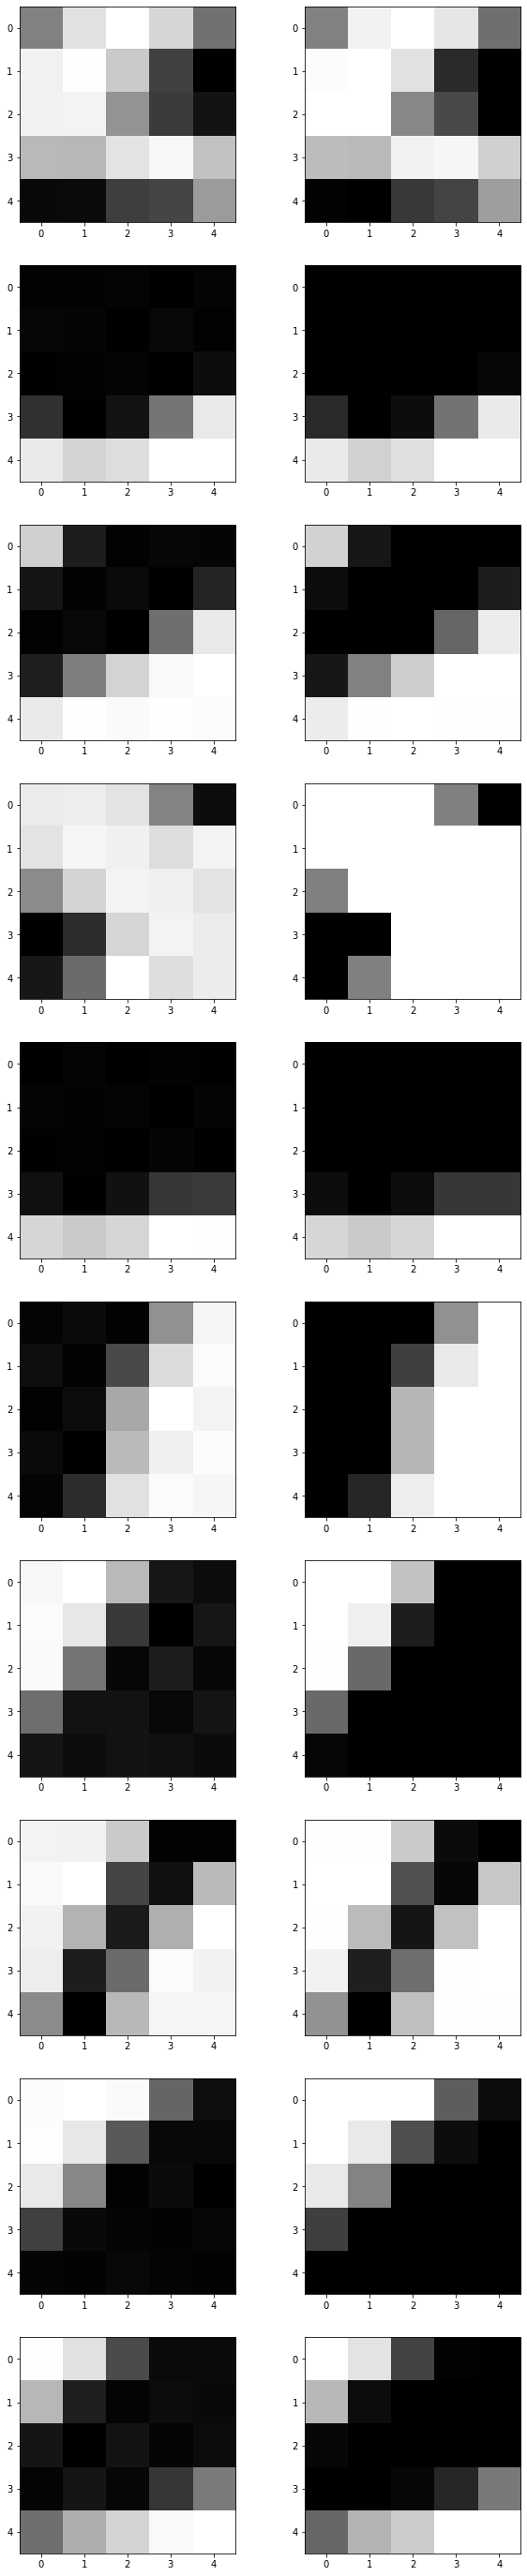

In [54]:
# look at sample reconstructed images
nrows = 10
start_idx = 5000
fig, axs = plt.subplots(nrows,2,figsize=(10,nrows*5))
real_images = np.reshape(x_test3[start_idx:start_idx+10,:], (nrows,5,5))
output_images = np.reshape(model33(x_test_encoded3[start_idx:start_idx+10,:]), (nrows,5,5))
for i in range(nrows):
    axs[i,0].imshow(output_images[i,:,:],
                    cmap='gray')
    axs[i,1].imshow(real_images[i,:,:],
                    cmap='gray')
    

## 4: Comparison of Jacobian with CRLB for the network in 3.3
### Plot original image x, output image y, x-y, (A * A.T)^-1, J * J.T

In [43]:
A3.shape

(25, 100)

Original image x
[[0.1569 0.9569 0.6941 0.     0.0078]
 [0.6314 0.9961 0.949  0.1569 0.4745]
 [0.5137 0.9961 0.9961 0.9961 0.9961]
 [0.1059 0.9529 0.9961 0.9961 0.9961]
 [0.     0.4706 0.7647 0.9255 0.3922]]
Encoded image x_encoded
[[-1.8667 -0.9559 -2.7032 -4.7686 -6.1052  1.4482  3.0624  1.7584  1.091
  -4.1655]
 [ 1.0511  1.5031  1.2076  1.0903  1.8297 -3.0033 -6.064   1.7373 -0.6427
  -9.5296]
 [-7.0928 -3.5105  2.0454  4.3141 -3.7147 -2.0354 -1.0815 -3.4715  9.7612
   8.7311]
 [ 5.969  -5.9624  2.5208 -0.3112 -5.7585  1.2866  5.1564 -0.3139  1.0456
  -1.9444]
 [-5.7891  1.0535 -3.8876  7.0148 -3.3615  0.9999  2.8402 -0.7361 -0.1624
   5.6788]
 [ 3.1714 -2.21   -2.2558  5.0019 -0.2011  1.9141  2.7324 -1.3515  1.1579
  -3.0379]
 [ 1.5937  0.1929  0.9736 -1.8109  0.6799 -4.121   0.6936  3.6939  5.072
   1.4832]
 [ 4.3679  1.0976 -0.6159 -7.1696  1.9222  4.0716 -3.6241  4.5659  2.4117
  -6.8578]
 [ 3.4892  2.7617 -0.7406  5.5505 -2.5015  3.5593  7.0331 -0.1839 -2.273
   1.0203]
 [ 2.3

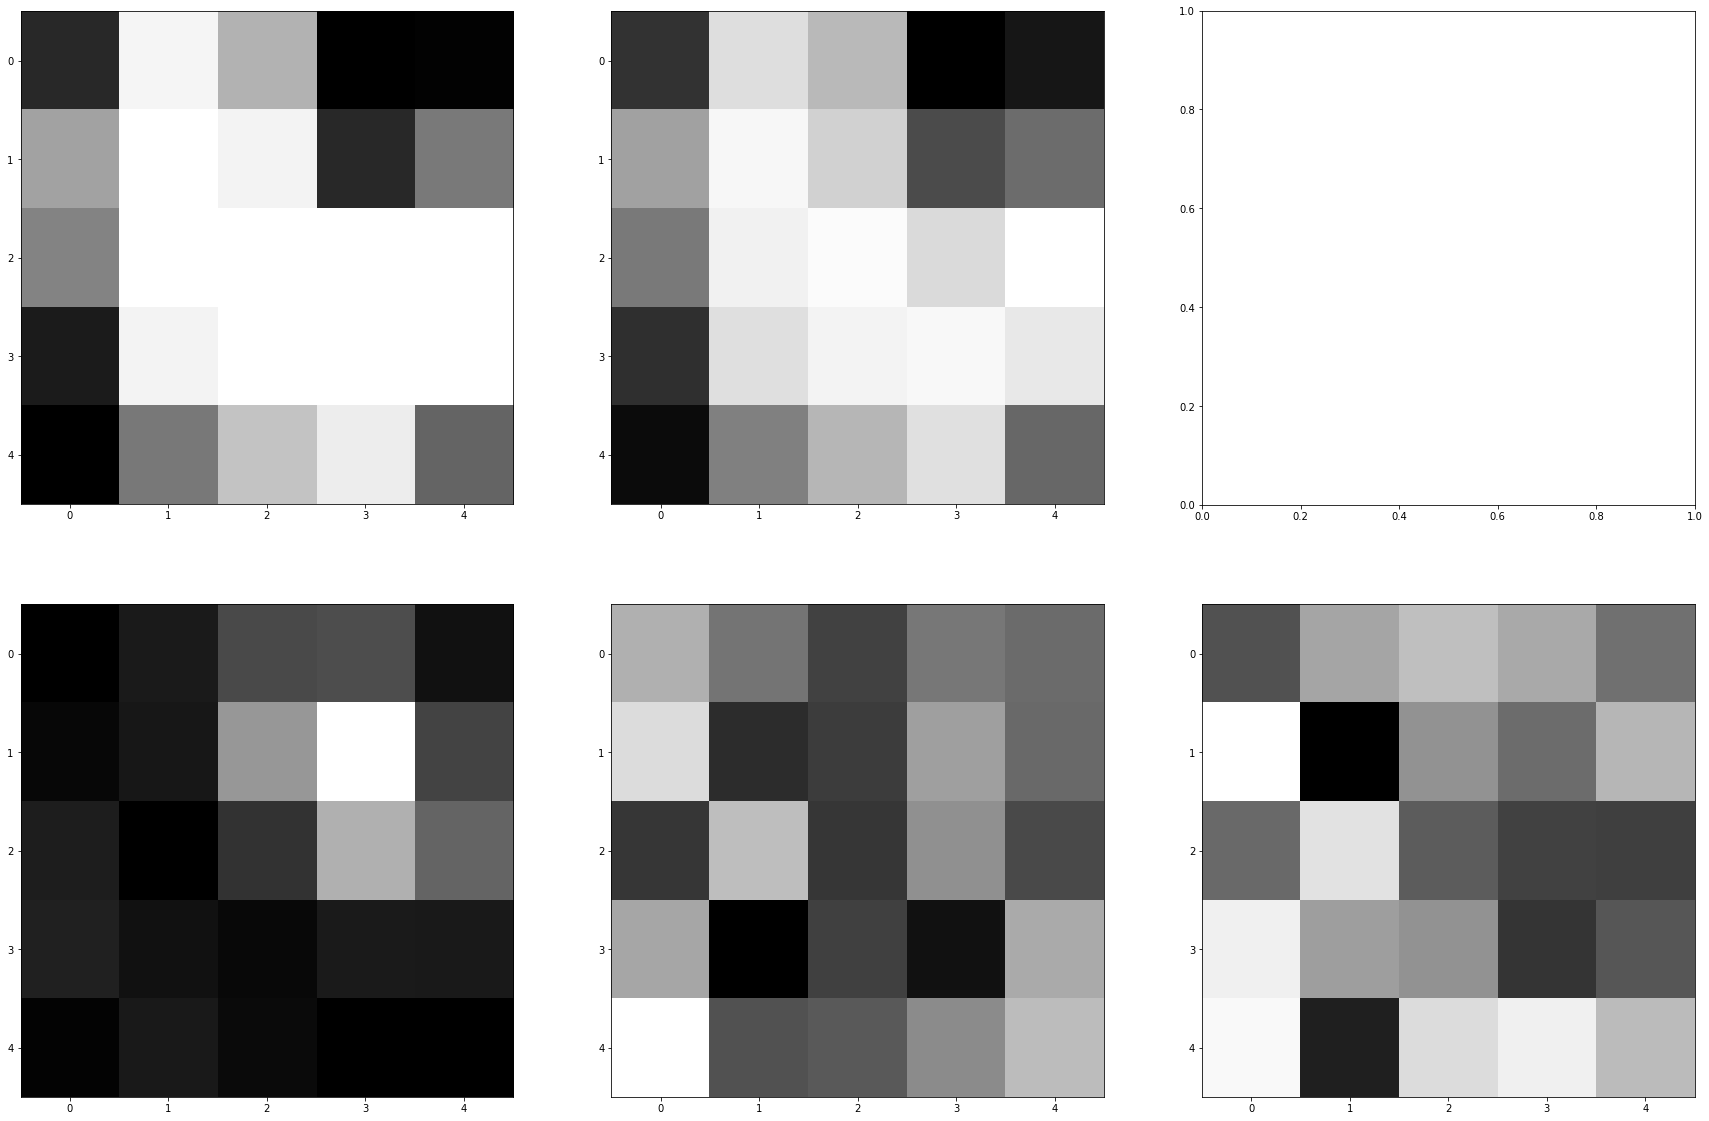

In [53]:
idx = 1000
x = x_test3[idx:idx+1,:]
x_encoded = tf.Variable(x_test_encoded3[idx:idx+1,:])
with tf.GradientTape() as tape:
    y = model33(x_encoded)

# output gradient of target w.r.t. sources
j = np.reshape(tape.jacobian(y, x_encoded), (25,100))
BTB = np.diagonal(j @ np.transpose(j))
ATA_inv = np.diagonal(np.linalg.inv(A3 @ np.transpose(A3)))

fig, axs = plt.subplots(2,3,figsize=(30,20))
axs[0,0].imshow(np.reshape(x[0],(5,5)), cmap='gray')
print('Original image x')
print(np.reshape(x[0],(5,5)))
print('Encoded image x_encoded')
print(np.reshape(x_encoded[0],(10,10)))
axs[0,1].imshow(np.reshape(y[0],(5,5)), cmap='gray')
print('Network output y')
print(np.reshape(y[0],(5,5)))
axs[1,0].imshow(np.reshape((x[0]-y[0])**2,(5,5)), cmap='gray')
print('(x-y)^2')
print(np.reshape((x[0]-y[0])**2,(5,5)))
axs[1,1].imshow(np.reshape(BTB,(5,5)), cmap='gray')
print('J * Jt')
print(np.reshape(BTB,(5,5)))
axs[1,2].imshow(np.reshape(ATA_inv,(5,5)), cmap='gray')
print('(A * At)^-1')
print(np.reshape(ATA_inv,(5,5)))

plt.show()

#        X                                       Y                      

In [ ]:
#      (X-Y)^2                                  diag(J*Jt)                  diag((A*At)^-1)

In [49]:
np.reshape((x[0]-y[0])**2,(5,5))

array([[0.    , 0.0013, 0.0036, 0.0038, 0.0009],
       [0.0004, 0.0012, 0.0075, 0.0126, 0.0033],
       [0.0015, 0.    , 0.0025, 0.0087, 0.0049],
       [0.0017, 0.0009, 0.0004, 0.0013, 0.0013],
       [0.0002, 0.0013, 0.0005, 0.    , 0.    ]], dtype=float32)

In [50]:
np.reshape(x[0], (5,5))

array([[0.1569, 0.9569, 0.6941, 0.    , 0.0078],
       [0.6314, 0.9961, 0.949 , 0.1569, 0.4745],
       [0.5137, 0.9961, 0.9961, 0.9961, 0.9961],
       [0.1059, 0.9529, 0.9961, 0.9961, 0.9961],
       [0.    , 0.4706, 0.7647, 0.9255, 0.3922]])